# PROJET DATA MINING 
## NESR Mohamad p1811466

In [207]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
import graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import v_measure_score
from yellowbrick.cluster import silhouette_visualizer
from sklearn import mixture
import missingno as msno
import folium
from sklearn.decomposition import PCA
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
import scipy.cluster.hierarchy as shc
from mlxtend.frequent_patterns import apriori
from sklearn import datasets
from sklearn.mixture import GaussianMixture

In [208]:
from google.colab import files
import io

uploaded = files.upload()

data = pd.read_csv(io.BytesIO(uploaded['energy.csv']), sep=',')
data = pd.read_csv('./energy.csv', sep=',')

Saving energy.csv to energy (2).csv


In [209]:
print(data.shape)
data.head(6)

(55440, 11)


,Unnamed: 0,Country,Energy_type,Year,Energy_consumption,Energy_production,GDP,Population,Energy_intensity_per_capita,Energy_intensity_by_GDP,CO2_emission
0,0,World,all_energy_types,1980,292.899790,296.337228,27770.910281,4.298127e+06,68.145921,10.547,4946.627130
1,1,World,coal,1980,78.656134,80.114194,27770.910281,4.298127e+06,68.145921,10.547,1409.790188
2,2,World,natural_gas,1980,53.865223,54.761046,27770.910281,4.298127e+06,68.145921,10.547,1081.593377
3,3,World,petroleum_n_other_liquids,1980,132.064019,133.111109,27770.910281,4.298127e+06,68.145921,10.547,2455.243565
4,4,World,nuclear,1980,7.575700,7.575700,27770.910281,4.298127e+06,68.145921,10.547,0.000000
5,5,World,renewables_n_other,1980,20.702344,20.775178,27770.910281,4.298127e+06,68.145921,10.547,0.000000


## Nettoyage des donnees

Il y a plusieurs raisons pour lesquelles il est important de nettoyer les données. Le nettoyage des données peut aider à améliorer les performances et la précision des algorithmes d’analyse des données et d’apprentissage automatique. En supprimant les valeurs aberrantes et le bruit des données, ces algorithmes peuvent être plus précis et efficaces. Enfin, le nettoyage de données peut aider à les rendre plus accessibles et compréhensibles pour les autres. En supprimant les informations inutiles ou non pertinentes, les données deviennent plus faciles à utiliser et à interpréter.

Nous avons une colonne inutile nommée unnamed. On l'enlève.

In [210]:
data = data.drop(['Unnamed: 0'], axis=1)

In [211]:
data['Year'] = data['Year'].astype('object')

In [212]:
for var in data:
    print(f'{var}: {data[var].isnull().sum()}')

Country: 0
Energy_type: 0
Year: 0
Energy_consumption: 11153
Energy_production: 11151
GDP: 15414
Population: 9426
Energy_intensity_per_capita: 5082
Energy_intensity_by_GDP: 5082
CO2_emission: 3826


On remarque qu'on a beaucoup de données manquantes.

Vu qu'on a plein de données qui manquent, on supprime alors les années avant 1990 pour réduire le nombre de donnes manquantes (les données les moins récentes peuvent être moins précises.). Et on enlève les lignes ou l'émission de CO2 est introuvable.

In [213]:
data = data.loc[data['Year']>=1990].copy()
data.dropna(subset=['CO2_emission'], inplace=True)

On supprime également les pays ayant une population nulle dans notre dataset

In [214]:
# on supprime toutes les lignes avec au moins 5 donnes manquantes
data.dropna(thresh=5, axis=0, inplace=True)

temp_pop = pd.DataFrame(data[data['Population'].isnull()])
cont = temp_pop['Country'].unique()
for c in cont:
    data.drop(labels=data[data['Country']==c].index, axis=0, inplace=True)

Le manque qu'on a dans Energy_consumption et Energy_production est peut-être dû au fait que certains pays n'ont pas d'énergie nucléaire. On met donc ces lignes a 0.

In [215]:
# On reccupere les lignes correspondant a l'energie nucleaire
nuclear = data.loc[data['Energy_type']=='nuclear'].copy()
# On reccupere le reste de notre dataset
temp_ecp = data.loc[data['Energy_type']!='nuclear'].copy()
# On remplace tout les nan par 0
nuclear[['Energy_consumption', 'Energy_production']] = nuclear[['Energy_consumption', 'Energy_production']].replace(np.nan, 0)
# On concatene nos 2 dataframes ensemble
data = pd.concat([nuclear, temp_ecp]).sort_index()

Certains pays n'ont souvent pas de données de GDP. On supprime alors tout pays ayant des valeurs de GDP manquantes. (GDP = PIB)

In [216]:
temp_gdp = pd.DataFrame(data['GDP'].isnull().groupby(data['Country']).sum()).reset_index()
temp_gdp = temp_gdp[temp_gdp['GDP']>=1]
print(temp_gdp)

                      Country  GDP
3              American Samoa   78
47                     Cyprus   30
74                       Guam   78
92                     Jordan   12
118                   Moldova   14
133  Northern Mariana Islands   53


On procède alors en enlevant ces pays.

In [217]:
for c in temp_gdp['Country']:
  data.drop(labels=data[data['Country']==c].index, axis=0, inplace=True)

In [218]:
for var in data:
    print(f'{var}: {data[var].isnull().sum()}')

Country: 0
Energy_type: 0
Year: 0
Energy_consumption: 0
Energy_production: 0
GDP: 0
Population: 0
Energy_intensity_per_capita: 897
Energy_intensity_by_GDP: 897
CO2_emission: 0


2 colonnes ne sont pas intéressantes dans notre étude Energy_intensity_per_capita et Energy_intensity_by_GDP. On va donc les supprimer.

In [219]:
data = data.drop(['Energy_intensity_per_capita'], axis=1)
data = data.drop(['Energy_intensity_by_GDP'], axis=1)

In [220]:
for var in data:
    print(f'{var}: {data[var].isnull().sum()}')

Country: 0
Energy_type: 0
Year: 0
Energy_consumption: 0
Energy_production: 0
GDP: 0
Population: 0
CO2_emission: 0


Finalement, nos donnees sont propres et on peut demarrer nos analyses.

## Normalisation des donnees

La normalisation est un processus utilisé pour mettre à l’échelle les données à une plage spécifique. Ceci est souvent fait pour mettre toutes les données sur la même échelle, ce qui peut être utile pour comparer des données provenant de différentes sources ou pour appliquer des algorithmes d’apprentissage automatique qui nécessitent que les données se trouvent dans une plage spécifique.  En outre, la normalisation des données peut aider à réduire la complexité des données, ce qui peut faciliter leur utilisation et leur interprétation.

Par exemple, si on veut comparer la population aux émissions de CO2, on se rend compte que l'échelle des deux données est différente ce qui n'est pas optimal pour l'analyse des données. De cette manière, toutes nos données seront sur une échelle similaire.

In [221]:
from sklearn import preprocessing
# on selection que les colonnes ayant des valeurs numeriques afin de les normaliser
numerical = data[['Energy_consumption','Energy_production','GDP','Population','CO2_emission']].copy()
ss = preprocessing.StandardScaler()
numerical_scaled = ss.fit_transform(numerical)
df = pd.DataFrame(numerical_scaled).astype(float)
print(df)

               0          1         2          3          4
0      21.596159  22.137780  7.704361  10.732956  21.441941
1       5.784851   6.060242  7.704361  10.732956   8.856129
2       4.511917   4.606146  7.704361  10.732956   3.721912
3       8.255573   8.365018  7.704361  10.732956   8.678035
4       1.151400   1.166440  7.704361  10.732956  -0.092933
...          ...        ...       ...        ...        ...
34502  -0.094956  -0.093829 -0.128660  -0.108741  -0.088475
34503  -0.097721  -0.098549 -0.128660  -0.108741  -0.092933
34504  -0.094316  -0.098549 -0.128660  -0.108741  -0.088678
34505  -0.097721  -0.098549 -0.128660  -0.108741  -0.092933
34506  -0.093543  -0.094355 -0.128660  -0.108741  -0.092933

[34507 rows x 5 columns]


In [222]:
# on selectionne les colonnes contenant des caracteres
characters = pd.DataFrame(data[['Country','Energy_type','Year']])
print(characters)

        Country                Energy_type  Year
13860     World           all_energy_types  1990
13861     World                       coal  1990
13862     World                natural_gas  1990
13863     World  petroleum_n_other_liquids  1990
13864     World                    nuclear  1990
...         ...                        ...   ...
55435  Zimbabwe                       coal  2019
55436  Zimbabwe                natural_gas  2019
55437  Zimbabwe  petroleum_n_other_liquids  2019
55438  Zimbabwe                    nuclear  2019
55439  Zimbabwe         renewables_n_other  2019

[34507 rows x 3 columns]


In [223]:
# on merge nos 2 dataframes ensemble afin d'obtenir un dataframe contenant nos colonnes de caracteres et nos colonnes avec les donnees normalise.
new_df = pd.DataFrame(np.hstack([characters,df]))
print(new_df)

              0                          1     2          3         4  \
0         World           all_energy_types  1990  21.596159  22.13778   
1         World                       coal  1990   5.784851  6.060242   
2         World                natural_gas  1990   4.511917  4.606146   
3         World  petroleum_n_other_liquids  1990   8.255573  8.365018   
4         World                    nuclear  1990     1.1514   1.16644   
...         ...                        ...   ...        ...       ...   
34502  Zimbabwe                       coal  2019  -0.094956 -0.093829   
34503  Zimbabwe                natural_gas  2019  -0.097721 -0.098549   
34504  Zimbabwe  petroleum_n_other_liquids  2019  -0.094316 -0.098549   
34505  Zimbabwe                    nuclear  2019  -0.097721 -0.098549   
34506  Zimbabwe         renewables_n_other  2019  -0.093543 -0.094355   

              5          6          7  
0      7.704361  10.732956  21.441941  
1      7.704361  10.732956   8.856129  
2  

In [224]:
# le nom des colonnes a disparru apres la normalisation, on renomme donc nos colonnes
new_df.columns=["Country","Energy_type","Year","Energy_consumption","Energy_production","GDP","Population","CO2_emission"]

print(new_df)
# on met a jour notre base de donnees et on convertis nos colonnes normalisee en float
data = new_df.copy()
data[["Energy_consumption","Energy_production","GDP","Population","CO2_emission"]] = data[["Energy_consumption","Energy_production","GDP","Population","CO2_emission"]].astype(float)

        Country                Energy_type  Year Energy_consumption  \
0         World           all_energy_types  1990          21.596159   
1         World                       coal  1990           5.784851   
2         World                natural_gas  1990           4.511917   
3         World  petroleum_n_other_liquids  1990           8.255573   
4         World                    nuclear  1990             1.1514   
...         ...                        ...   ...                ...   
34502  Zimbabwe                       coal  2019          -0.094956   
34503  Zimbabwe                natural_gas  2019          -0.097721   
34504  Zimbabwe  petroleum_n_other_liquids  2019          -0.094316   
34505  Zimbabwe                    nuclear  2019          -0.097721   
34506  Zimbabwe         renewables_n_other  2019          -0.093543   

      Energy_production       GDP Population CO2_emission  
0              22.13778  7.704361  10.732956    21.441941  
1              6.060242  7.

## Analyses

Nous allons mener une étude comparative entre nos différentes données et leurs effets sur les émissions de CO2.

#### Émissions totales de CO2 de la planète au cours des années

In [225]:
world_data = data.loc[data['Country']=='World'].copy()

In [226]:
world_data.shape

(180, 8)

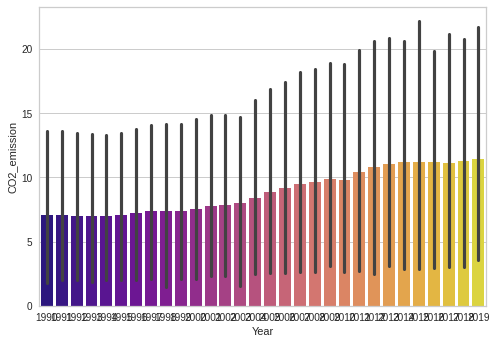

In [227]:
sns.barplot(x="Year",y="CO2_emission",data=world_data,palette='plasma')

On peut voir une augmentation quasi-constante des émissions de CO2 sur la planète. Surement, certains pays contribuent beaucoup plus à ces émissions que d'autres. Nous allons alors regarder quels pays ont émis le plus en 1990 et en 2019.

On renomme 'United States' par 'United States of America' pour mieux utiliser folium plus tard.

In [228]:
data['Country'].loc[data['Country']=='United States'] = 'United States of America'

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [229]:
country_data1990 = data.loc[data['Year']==1990][data['Country']!='World' ][data['Energy_type']=='all_energy_types'].copy()
country_data2019 = data.loc[data['Year']==2019][data['Country']!='World' ][data['Energy_type']=='all_energy_types'].copy()

<ipython-input-229-0432d5fa5c2b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_data1990 = data.loc[data['Year']==1990][data['Country']!='World' ][data['Energy_type']=='all_energy_types'].copy()
<ipython-input-229-0432d5fa5c2b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_data2019 = data.loc[data['Year']==2019][data['Country']!='World' ][data['Energy_type']=='all_energy_types'].copy()


In [230]:
sorted_top6_1990 = country_data1990['CO2_emission'].nlargest(n=6)
sorted_top6_1990.head(6)

961    4.848498
210    2.252329
473    0.919415
955    0.489442
425    0.403315
180    0.361564
Name: CO2_emission, dtype: float64

In [231]:
biggest_emittors1990 = country_data1990.loc[country_data1990['CO2_emission']>=  0.354515].copy()

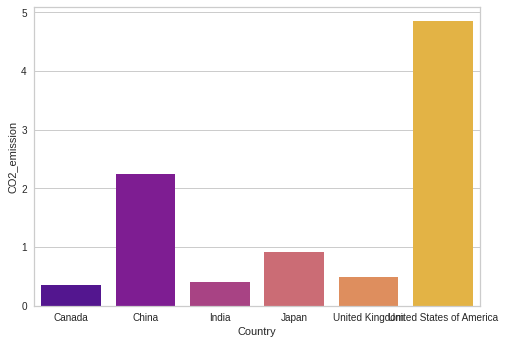

In [232]:
sns.barplot(x="Country",y="CO2_emission",data=biggest_emittors1990,palette='plasma')

In [233]:
world = folium.Map(location=[0,0], zoom_start=2)
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'
print(country_shapes)
folium.Choropleth(
    geo_data=country_shapes,
    name='CO2_emission',
    data=country_data1990,
    columns=['Country', 'CO2_emission'],
    key_on='feature.properties.name',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='CO2_emission'
  ).add_to(world)
folium.LayerControl(collapsed=False).add_to(world)
world.save('map.html')
world

https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json


In [234]:
sorted_top6_2019 = country_data2019['CO2_emission'].nlargest(n=6)
sorted_top6_2019.head(6)

33559    10.217040
34453     5.035709
33811     2.150421
34189     1.654690
33859     1.015900
33727     0.666662
Name: CO2_emission, dtype: float64

In [235]:
biggest_emittors2019 = country_data2019.loc[country_data2019['CO2_emission']>= 0.655655].copy()
biggest_emittors2019.head(6)

,Country,Energy_type,Year,Energy_consumption,Energy_production,GDP,Population,CO2_emission
33559,China,all_energy_types,2019,9.205157,7.581480,3.548139,2.806949,10.217040
33727,Germany,all_energy_types,2019,0.732696,0.182880,0.531269,0.031837,0.666662
33811,India,all_energy_types,2019,1.852500,1.006643,1.347853,2.670653,2.150421
33859,Japan,all_energy_types,2019,1.067136,0.073607,0.718686,0.121634,1.015900
34189,Russia,all_energy_types,2019,1.942320,3.895718,0.465724,0.160725,1.654690
34453,United States of America,all_energy_types,2019,6.065017,6.202555,3.038131,0.538914,5.035709


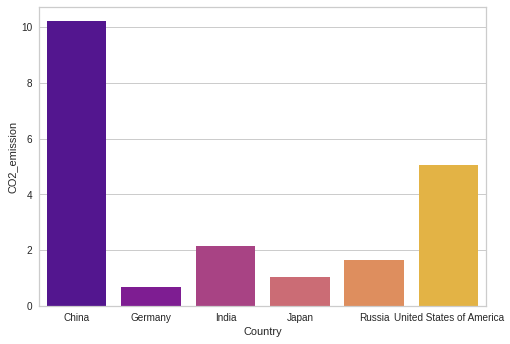

In [236]:
sns.barplot(x="Country",y="CO2_emission",data=biggest_emittors2019,palette='plasma')

In [237]:
world = folium.Map(location=[0,0], zoom_start=2)
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'
print(country_shapes)
folium.Choropleth(
    geo_data=country_shapes,
    name='CO2_emission',
    data=country_data2019,
    columns=['Country', 'CO2_emission'],
    key_on='feature.properties.name',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='CO2_emission'
  ).add_to(world)
folium.LayerControl(collapsed=False).add_to(world)
world.save('map.html')
world

https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json


Comme on peut observer, certains pays comme la Chine, les Etats-Unis, l'Inde et le Japon sont présents dans les 6 plus grands émetteurs de CO2 en 1990 et en 2019. Alors que le Canada et le Royaume Unis qui figurent en 1990 sont remplacés par la Russie et l'Allemagne en 2019. (On note que l'Union Soviétique a été retiré de la base, car cet état n'existe plus.)

On peut donc qualifier ces 4 pays présents en 1990 et en 2019 en tant que 'LEADERS' des émissions de CO2. On trace donc l'évolution de leurs émissions au cours des années.

#### CHINE

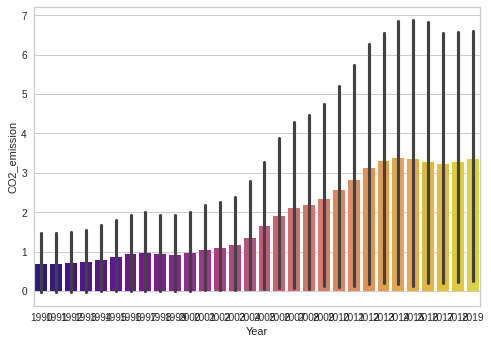

In [238]:
china_data = data.loc[data['Country']=='China'].copy()
sns.barplot(x="Year",y="CO2_emission",data=china_data,palette='plasma')

#### ETATS-UNIS

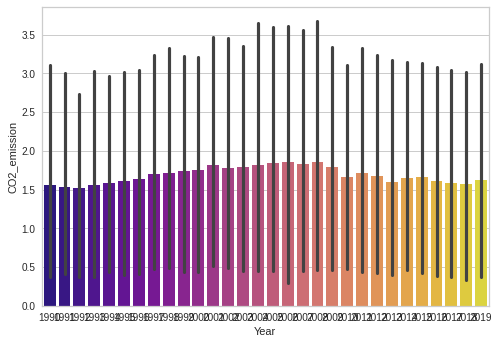

In [239]:
usa_data = data.loc[data['Country']=='United States of America'].copy()
sns.barplot(x="Year",y="CO2_emission",data=usa_data,palette='plasma')

#### JAPON

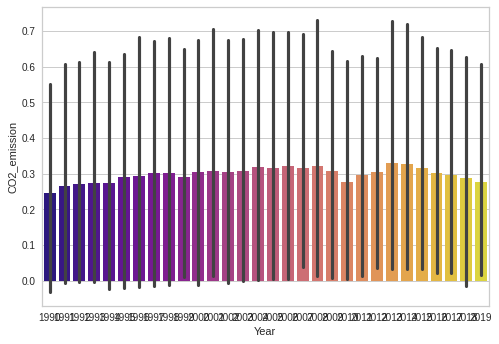

In [240]:
japan_data = data.loc[data['Country']=='Japan'].copy()
sns.barplot(x="Year",y="CO2_emission",data=japan_data,palette='plasma')

#### INDE

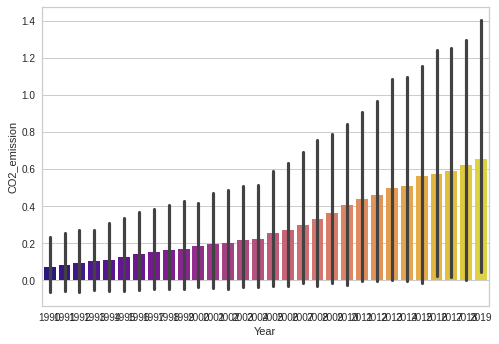

In [241]:
india_data = data.loc[data['Country']=='India'].copy()
sns.barplot(x="Year",y="CO2_emission",data=india_data,palette='plasma')

####Observation

On remarque que les Etats Unis et le Japon qui sont des pays du Nord ont réussi a garder leurs émissions stables sans grande évolution alors que la Chine et l'Inde qui sont des pays émargeants, ne font qu'augmenter leurs taux d'émissions.

## Combien de clusters peut on distinguer dans la base?

In [242]:
filtered = country_data2019.iloc[:, [3,4,5,6,7]]
filtered = np.array(filtered)
filtered

array([[-9.01894764e-02, -9.51185509e-02, -1.21998967e-01,
        -6.06955670e-02, -8.38057755e-02],
       [-9.09258199e-02, -9.30137284e-02, -1.28557159e-01,
        -1.32919465e-01, -8.90147590e-02],
       [ 6.44866170e-02,  3.01001067e-01, -5.35907543e-02,
        -5.04701227e-02,  4.89458826e-02],
       [-7.48688920e-02,  1.19576778e-01, -1.03787292e-01,
        -7.34295771e-02, -7.57846924e-02],
       [-9.70832916e-02, -9.85410480e-02, -1.34311747e-01,
        -1.38634098e-01, -9.22183784e-02],
       [ 1.19834545e-01,  1.18530297e-01, -1.93007137e-03,
        -4.67690848e-02,  9.30394042e-02],
       [-8.80991519e-02, -9.57589907e-02, -1.28987979e-01,
        -1.32760995e-01, -8.71243588e-02],
       [-9.65822936e-02, -9.84681719e-02, -1.34139949e-01,
        -1.38615120e-01, -9.17615685e-02],
       [ 2.94650944e-01,  1.07932001e+00,  6.06619411e-02,
        -8.66585236e-02,  3.06366870e-01],
       [-4.32835117e-03, -6.32853872e-02, -6.01763031e-02,
        -1.20587562e-01

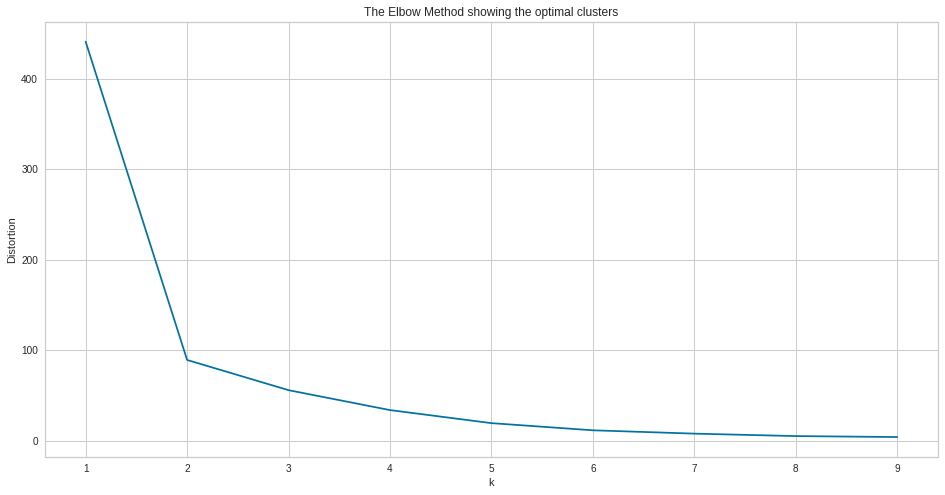

In [243]:
# Collecting the distortions into list
distortions = []
K = range(1,10)
for k in K:
 kmeanModel = KMeans(n_clusters=k)
 kmeanModel.fit(filtered)
 distortions.append(kmeanModel.inertia_)
# Plotting the distortions
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal clusters')
plt.show()

D'après la elbow method, on voit que 2 clusters est le nombre de clusters optimale pour séparer nos données.

In [244]:
# Define the model
kmeans_model = KMeans(n_clusters=2, random_state=0)
# Fit into our dataset fit
kmeans_predict = kmeans_model.fit_predict(filtered)
kmeans_predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [245]:
country_data2019['Clusters'] = kmeans_predict
country_data2019 

,Country,Energy_type,Year,Energy_consumption,Energy_production,GDP,Population,CO2_emission,Clusters
33331,Afghanistan,all_energy_types,2019,-0.090189,-0.095119,-0.121999,-0.060696,-0.083806,0
33337,Albania,all_energy_types,2019,-0.090926,-0.093014,-0.128557,-0.132919,-0.089015,0
33343,Algeria,all_energy_types,2019,0.064487,0.301001,-0.053591,-0.050470,0.048946,0
33349,Angola,all_energy_types,2019,-0.074869,0.119577,-0.103787,-0.073430,-0.075785,0
33355,Antigua and Barbuda,all_energy_types,2019,-0.097083,-0.098541,-0.134312,-0.138634,-0.092218,0
...,...,...,...,...,...,...,...,...,...
34477,Venezuela,all_energy_types,2019,0.052458,0.122155,-0.104373,-0.080276,0.034851,0
34483,Vietnam,all_energy_types,2019,0.117600,0.060305,0.011127,0.059178,0.142067,0
34489,Yemen,all_energy_types,2019,-0.087964,-0.090268,-0.126198,-0.078949,-0.084874,0
34495,Zambia,all_energy_types,2019,-0.085014,-0.089352,-0.095291,-0.102129,-0.086036,0


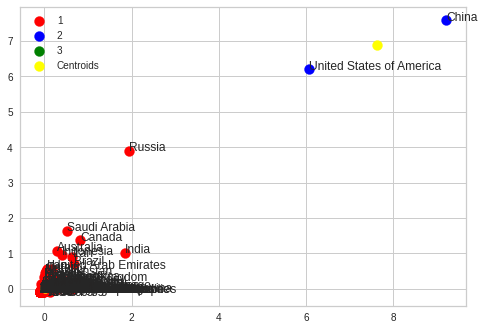

In [246]:
# Visualising the clusters
for i,label in enumerate(country_data2019['Country']):
  plt.annotate(label, xy=(filtered[i, 0],filtered[i, 1]))
plt.scatter(filtered[kmeans_predict == 0, 0], filtered[kmeans_predict == 0, 1], s = 100, c = 'red', label = '1')
plt.scatter(filtered[kmeans_predict == 1, 0], filtered[kmeans_predict == 1, 1], s = 100, c = 'blue', label = '2')
plt.scatter(filtered[kmeans_predict == 2, 0], filtered[kmeans_predict == 2, 1], s = 100, c = 'green', label = '3')

# Plotting the centroids of the clusters
plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')
plt.legend()


Nos clusters ne sont pas très impressionnants. On a un cluster contenant les USA et la Chine. Mais la Russie est incluse dans un cluster avec les autres pays alors qu'elle devrait être toute seule. Cela est l'un des défauts de k-means vu qu'on ne peut pas placer nos centroids a la main. Dans ce cas, le clustering à l'œil nu est mieux.

Voici une version sans label pour une meilleure visualisation:

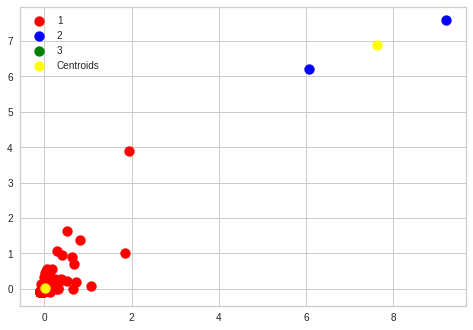

In [247]:
plt.scatter(filtered[kmeans_predict == 0, 0], filtered[kmeans_predict == 0, 1], s = 100, c = 'red', label = '1')
plt.scatter(filtered[kmeans_predict == 1, 0], filtered[kmeans_predict == 1, 1], s = 100, c = 'blue', label = '2')
plt.scatter(filtered[kmeans_predict == 2, 0], filtered[kmeans_predict == 2, 1], s = 100, c = 'green', label = '3')
# Plotting the centroids of the clusters
plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')
plt.legend()

La méthode du agglomerative clustering peut être plus utile ici. Grace a cette méthode hiérarchique, on pourra créer des clusters dont chacun contient les éléments les plus similaires à l'autre. 

On veut réduire la taille de nos données pour les observer en 2D. On applique donc le PCA.

Le PCA est une technique de réduction de dimensionnalité utilisée pour réduire la complexité d’un ensemble de données en le transformant en un espace de dimension inférieure. Cela se fait en trouvant un nouvel ensemble d’axes qui capturent la variation la plus importante dans les données. En projetant les données sur ces nouveaux axes, les données peuvent être représentées en utilisant moins de dimensions tout en conservant les informations les plus importantes. 

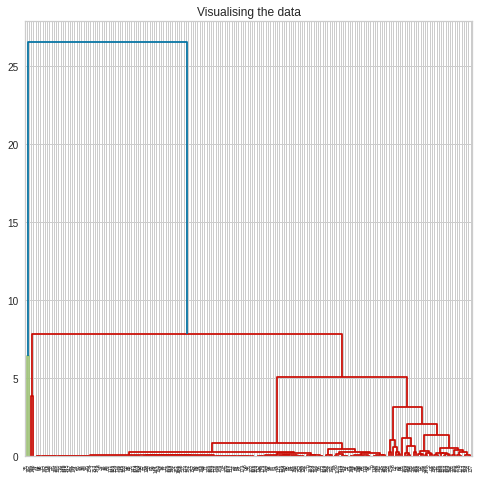

In [248]:
#X_normalized = normalize(filtered)
#X_normalized = pd.DataFrame(X_normalized)

pca = PCA(n_components = 2)
X_principal = pca.fit_transform(filtered)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

plt.figure(figsize =(8, 8))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))

D'apres le dendogramme on a 2 branches separees. mais cela ne signiie pas que c'est le nombre de clusters optimale. On choisis donc notre nombre de clustersen fonction du silhouette score.

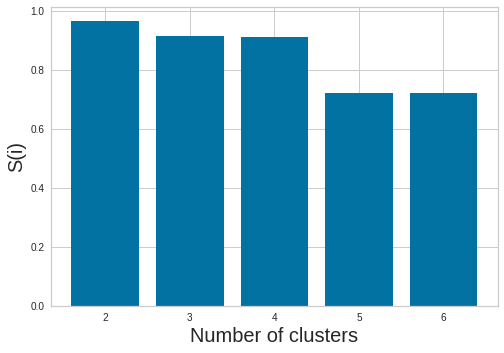

In [249]:
k = [2, 3, 4, 5, 6]
 
# Appending the silhouette scores of the different models to the list
silhouette_scores = []
silhouette_scores.append(
        silhouette_score(X_principal, AgglomerativeClustering(n_clusters = 2).fit_predict(X_principal)))
silhouette_scores.append(
        silhouette_score(X_principal, AgglomerativeClustering(n_clusters = 3).fit_predict(X_principal)))
silhouette_scores.append(
        silhouette_score(X_principal, AgglomerativeClustering(n_clusters = 4).fit_predict(X_principal)))
silhouette_scores.append(
        silhouette_score(X_principal, AgglomerativeClustering(n_clusters = 5).fit_predict(X_principal)))
silhouette_scores.append(
        silhouette_score(X_principal, AgglomerativeClustering(n_clusters = 6).fit_predict(X_principal)))
 
# Plotting a bar graph to compare the results
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

On remarque qu'on a le meilleur score pour 2 clusters. On garde alors ce nombre de clusters pour notre travail

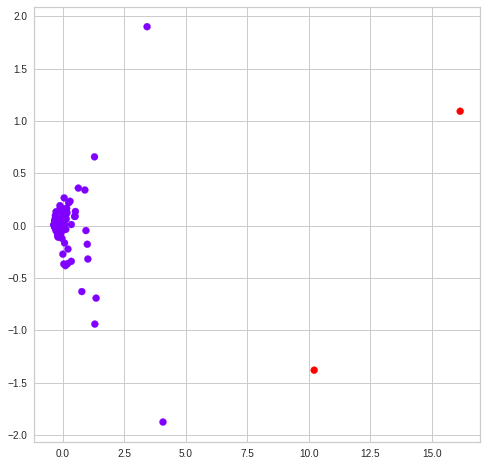

In [250]:
ac = AgglomerativeClustering(n_clusters = 2)
# Visualising the clusters
plt.figure(figsize =(8, 8))
plt.scatter(X_principal['P1'], X_principal['P2'],
           c = ac.fit_predict(X_principal), cmap ='rainbow')
plt.show()

On peut clairement distinguer nos 2 clusters. Le cluster en rouge correspond aux principaux contributeurs aux émissions de CO2. D'autre part, les pays en violet contribuent moins.

Dans notre cas, la réduction de la précision de peu pourra nous permettre de mieux visualiser les résultats. On procède donc en passant a 3 clusters.

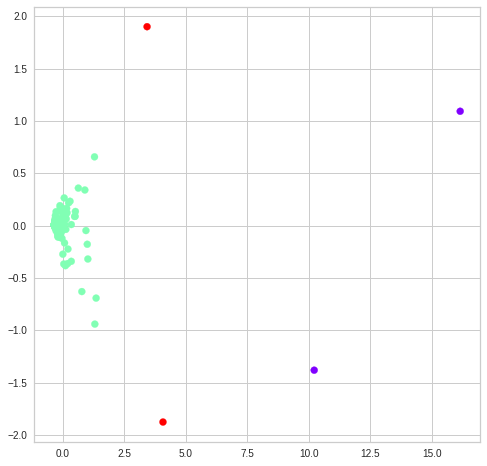

In [251]:
ac = AgglomerativeClustering(n_clusters = 3)
# Visualising the clusters
plt.figure(figsize =(8, 8))
plt.scatter(X_principal['P1'], X_principal['P2'],
           c = ac.fit_predict(X_principal), cmap ='rainbow')
plt.show()

Ce résultat  est mieux. Vu qu'on a nos 2 principaux contributeurs en violet (Chine & USA), les 2 suivants en rouge (Russie & Inde), et le reste du monde en bleu/vert.

On aurait pu faire notre kmeans également avec 3 clusters pour le même résultat, mais vu qu'on a suivis la elbow method, cela n'a pas était fait.

Voici le même résultat avec k-means et k=3:

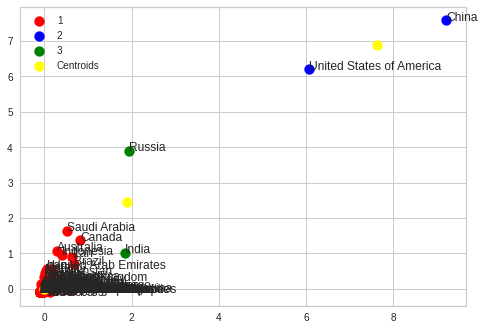

In [252]:
# Define the model
kmeans_model = KMeans(n_clusters=3, random_state=0)
# Fit into our dataset fit
kmeans_predict = kmeans_model.fit_predict(filtered)
kmeans_predict

country_data2019['Clusters'] = kmeans_predict
country_data2019 

# Visualising the clusters
for i,label in enumerate(country_data2019['Country']):
  plt.annotate(label, xy=(filtered[i, 0],filtered[i, 1]))
plt.scatter(filtered[kmeans_predict == 0, 0], filtered[kmeans_predict == 0, 1], s = 100, c = 'red', label = '1')
plt.scatter(filtered[kmeans_predict == 1, 0], filtered[kmeans_predict == 1, 1], s = 100, c = 'blue', label = '2')
plt.scatter(filtered[kmeans_predict == 2, 0], filtered[kmeans_predict == 2, 1], s = 100, c = 'green', label = '3')

# Plotting the centroids of the clusters
plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')
plt.legend()

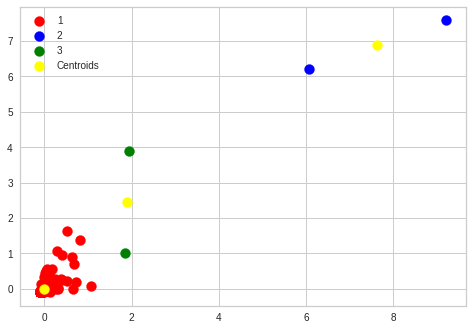

In [253]:


plt.scatter(filtered[kmeans_predict == 0, 0], filtered[kmeans_predict == 0, 1], s = 100, c = 'red', label = '1')
plt.scatter(filtered[kmeans_predict == 1, 0], filtered[kmeans_predict == 1, 1], s = 100, c = 'blue', label = '2')
plt.scatter(filtered[kmeans_predict == 2, 0], filtered[kmeans_predict == 2, 1], s = 100, c = 'green', label = '3')

# Plotting the centroids of the clusters
plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')
plt.legend()

## Effet des autres caractéristiques sur les émissions de CO2

### GDP et population

In [254]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
 

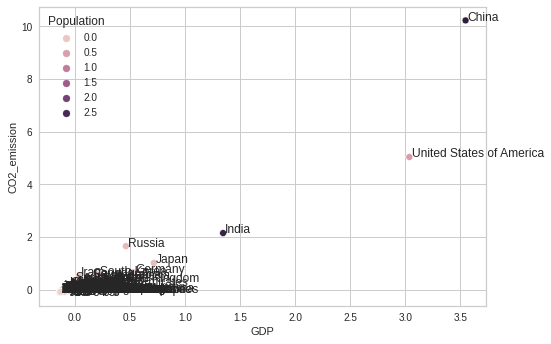

In [255]:
GDP = country_data2019['GDP']
CO2_emission = country_data2019["CO2_emission"]
Population = country_data2019["Population"]
Country = country_data2019["Country"]

line = sns.scatterplot(data=country_data2019,x="GDP",y="CO2_emission",hue="Population")


label_point(GDP, CO2_emission,Country, line)

Comme on peut voir, la Chine, les Etats Unis et l'Inde sont les 3 pays qui se distinguent le plus du reste du monde. À quoi cela est dû ?
Comme on peut voir dans notre graphe, nous avons créé des clusters en fonction de la population. Et on peut voir clairement la présence de l'Inde et de la Chine dans le cluster 2.5 (plus grand pour la population) et la présence des Etats Unis dans 0.5 alors que le reste du monde est dans le cluster 0.0. De même, les 3 pays les plus à droite (GDP haut) sont ces 3 pays. Aussi, les trois pays les plus « hauts » sont ces 3 pays (émission de CO2 haute). 

On vérifie cela en regardant nos 3 pays avec le plus haut GDP et les plus peuplées.

In [256]:
sorted_top3_GDP_2019 = country_data2019['GDP'].nlargest(n=3)
sorted_top3_GDP_2019

33559    3.548139
34453    3.038131
33811    1.347853
Name: GDP, dtype: float64

In [257]:
biggest_GDP2019 = country_data2019.loc[country_data2019['GDP']>= 1.327026].copy()
biggest_GDP2019

,Country,Energy_type,Year,Energy_consumption,Energy_production,GDP,Population,CO2_emission,Clusters
33559,China,all_energy_types,2019,9.205157,7.581480,3.548139,2.806949,10.217040,1
33811,India,all_energy_types,2019,1.852500,1.006643,1.347853,2.670653,2.150421,2
34453,United States of America,all_energy_types,2019,6.065017,6.202555,3.038131,0.538914,5.035709,1


In [258]:
sorted_top6_Population_2019 = country_data2019['Population'].nlargest(n=6)
sorted_top6_Population_2019

33559    2.806949
33811    2.670653
34453    0.538914
33817    0.417634
34111    0.305883
33469    0.294962
Name: Population, dtype: float64

In [259]:
biggest_pop2019 = country_data2019.loc[country_data2019['Population']>= 0.528361].copy()
biggest_pop2019

,Country,Energy_type,Year,Energy_consumption,Energy_production,GDP,Population,CO2_emission,Clusters
33559,China,all_energy_types,2019,9.205157,7.581480,3.548139,2.806949,10.217040,1
33811,India,all_energy_types,2019,1.852500,1.006643,1.347853,2.670653,2.150421,2
34453,United States of America,all_energy_types,2019,6.065017,6.202555,3.038131,0.538914,5.035709,1


Comme attendu, les 3 pays les plus peuples et les 3 pays avec le plus haut GDP sont les mêmes et ce sont les 3 principaux contributeurs aux émissions de CO2.

### Relation entre l'énergie et les émissions de CO2

On va tout d'abord vérifier la relation entre la production et la consommation de l'énergie. Est ce qu'un pays qui produit beaucoup d'énergie en consomme également plus ?

33331   -0.090189
33337   -0.090926
33343    0.064487
33349   -0.074869
33355   -0.097083
           ...   
34477    0.052458
34483    0.117600
34489   -0.087964
34495   -0.085014
34501   -0.087373
Name: Energy_consumption, Length: 196, dtype: float64


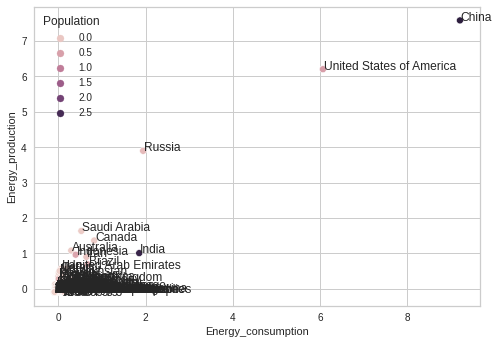

In [260]:
Energy_consumption = country_data2019['Energy_consumption']
Energy_production = country_data2019["Energy_production"]

line = sns.scatterplot(data=country_data2019,x="Energy_consumption",y="Energy_production",hue="Population")


label_point(Energy_consumption, Energy_production,Country, line)
print(Energy_consumption)

On peut voir que c'est le cas pour 2 des 4 plus grands émetteurs de CO2 (USA, Chine). Beaucoup de production signifie également beaucoup de consommation. L'Inde consomme 2 fois plus que sa production. La Russie produit 2 fois plus que sa consommation.

On va donc confirmer si ces 2 colonnes ont un effet sur les émissions de CO2. Cela nous laisse avec 3 dimensions. On veut pourtant les représenter en deux dimensions. Pour cela, on va appliquer le PCA.

In [261]:
data_energy = pd.concat([Energy_production,Energy_consumption],axis=1)
print(data_energy)

       Energy_production  Energy_consumption
33331          -0.095119           -0.090189
33337          -0.093014           -0.090926
33343           0.301001            0.064487
33349           0.119577           -0.074869
33355          -0.098541           -0.097083
...                  ...                 ...
34477           0.122155            0.052458
34483           0.060305            0.117600
34489          -0.090268           -0.087964
34495          -0.089352           -0.085014
34501          -0.089635           -0.087373

[196 rows x 2 columns]


In [262]:
data_energy_co2 = pd.concat([data_energy,CO2_emission], axis = 1)
print(data_energy_co2)

       Energy_production  Energy_consumption  CO2_emission
33331          -0.095119           -0.090189     -0.083806
33337          -0.093014           -0.090926     -0.089015
33343           0.301001            0.064487      0.048946
33349           0.119577           -0.074869     -0.075785
33355          -0.098541           -0.097083     -0.092218
...                  ...                 ...           ...
34477           0.122155            0.052458      0.034851
34483           0.060305            0.117600      0.142067
34489          -0.090268           -0.087964     -0.084874
34495          -0.089352           -0.085014     -0.086036
34501          -0.089635           -0.087373     -0.084220

[196 rows x 3 columns]


In [263]:
principal=PCA(n_components=2)
principal.fit(data_energy_co2)
result_pca = principal.transform(data_energy_co2)
print(result_pca.shape)

(196, 2)


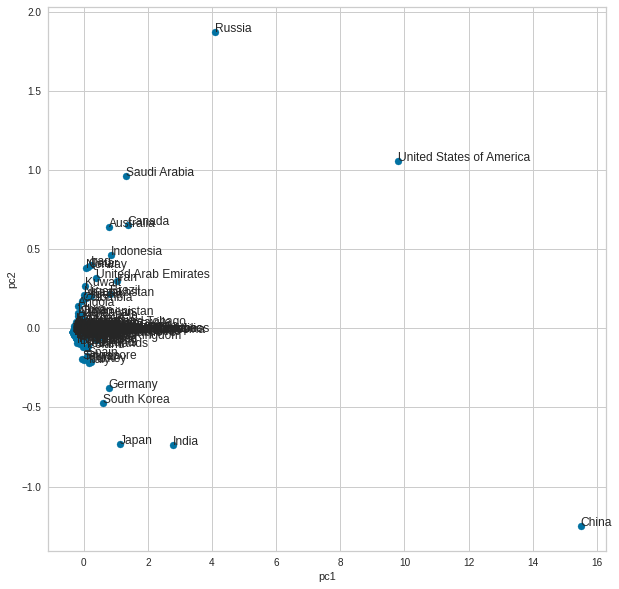

In [264]:
plt.figure(figsize=(10,10))
plt.scatter(result_pca[:,0],result_pca[:,1])
plt.xlabel('pc1')
plt.ylabel('pc2')
for i,label in enumerate(Country):
  plt.annotate(label, xy=(result_pca[i,0],result_pca[i,1]))


In [265]:
cn2019 = country_data2019.loc[country_data2019['Country']== 'China'].copy()
print(cn2019)
print('\n')
ru2019 = country_data2019.loc[country_data2019['Country']== 'Russia'].copy()
print(ru2019)
print('\n')
usa2019 = country_data2019.loc[country_data2019['Country']== 'United States of America'].copy()
print(usa2019)

      Country       Energy_type  Year  Energy_consumption  Energy_production  \
33559   China  all_energy_types  2019            9.205157            7.58148   

            GDP  Population  CO2_emission  Clusters  
33559  3.548139    2.806949      10.21704         1  


      Country       Energy_type  Year  Energy_consumption  Energy_production  \
34189  Russia  all_energy_types  2019             1.94232           3.895718   

            GDP  Population  CO2_emission  Clusters  
34189  0.465724    0.160725       1.65469         2  


                        Country       Energy_type  Year  Energy_consumption  \
34453  United States of America  all_energy_types  2019            6.065017   

       Energy_production       GDP  Population  CO2_emission  Clusters  
34453           6.202555  3.038131    0.538914      5.035709         1  


En observant ce graphe et les données de nos 3 principaux émetteurs, on remarque que pour une grande partie des données, les points sont proches et forment un cluster sur (0,0). Cependant, on distingue 3 pays écartés des autres. Ce sont bien nos pays responsables du plus grand taux d'émissions.
On peut distinguer donc 4 clusters à l'œil nu :
- La Russie : plus de production d'énergie que d'émission d'énergie/CO2 émis
- Les Etats Unis : plus de production/émission d'énergie que de CO2 émis
- La Chine : plus d'émission de CO2 que de production/émission d'énergie
- Le reste du monde : des taux assez similaires pour les 3 critères

#### Frequent pattern mining pour la relation énergie et émission de CO2

On va utiliser l'algorithme apriori afin de détecter les paternes qui se répètent entre la production/consommation d'énergie et les émissions de CO2.


In [266]:
mean_array = data_energy_co2.mean(axis=0)
print(mean_array)

Energy_production     0.095192
Energy_consumption    0.089788
CO2_emission          0.082930
dtype: float64


Nous avons obtenu la moyenne de nos colonnes. On va créer un bool pour chaque colonne qui va renvoyer false si la valeur est supérieure a la moyenne et true sinon. Cette méthode peut également fonctionner avec la médiane, mais dans notre cas, la moyenne est plus intéressante. Si on prend la médiane, on va devoir traiter la moitie des pays. Si on prend la moyenne, vu que l'écart entre les statistiques des pays est élevé, on va ne devoir traiter qu'une vingtaine de pays.

On va créer 3 colonnes booléennes.
- Xtra_CO2_emission : si l'émission de CO2 du pays est plus élevée que la moyenne mondiale, le booléen est à 1. Sinon, il est à 0.
- Xtra_Energy_production : si la production d'énergie du pays est plus élevée que la moyenne mondiale, le booléen est à 1. Sinon, il est à 0.
- Xtra_Energy_consumption : si la consommation d'énergie du pays est plus élevée que la moyenne mondiale, le booléen est à 1. Sinon, il est à 0.

Cela nous permettra de voir si une production/consommation basse d'énergie signifie des émissions basses de CO2.

In [267]:
#convert to dataframe
df = pd.DataFrame(data_energy_co2)
df["Xtra_CO2_emission"] = np.where((df['CO2_emission'] < 0.082930), 0, 1)
df["Xtra_Energy_production"] = np.where((df['Energy_production'] < 0.095192), 0, 1)
df["Xtra_Energy_consumption"] = np.where((df['Energy_consumption'] < 0.089788), 0, 1)
df["Country"] = Country
print(df)

       Energy_production  Energy_consumption  CO2_emission  Xtra_CO2_emission  \
33331          -0.095119           -0.090189     -0.083806                  0   
33337          -0.093014           -0.090926     -0.089015                  0   
33343           0.301001            0.064487      0.048946                  0   
33349           0.119577           -0.074869     -0.075785                  0   
33355          -0.098541           -0.097083     -0.092218                  0   
...                  ...                 ...           ...                ...   
34477           0.122155            0.052458      0.034851                  0   
34483           0.060305            0.117600      0.142067                  1   
34489          -0.090268           -0.087964     -0.084874                  0   
34495          -0.089352           -0.085014     -0.086036                  0   
34501          -0.089635           -0.087373     -0.084220                  0   

       Xtra_Energy_producti

In [268]:
apriori_df = df[['Xtra_CO2_emission','Xtra_Energy_production','Xtra_Energy_consumption']]
print(apriori_df)

       Xtra_CO2_emission  Xtra_Energy_production  Xtra_Energy_consumption
33331                  0                       0                        0
33337                  0                       0                        0
33343                  0                       1                        0
33349                  0                       1                        0
33355                  0                       0                        0
...                  ...                     ...                      ...
34477                  0                       1                        0
34483                  1                       0                        1
34489                  0                       0                        0
34495                  0                       0                        0
34501                  0                       0                        0

[196 rows x 3 columns]


Notre support doit être bas. Vu que nos principaux contributeurs ne sont pas nombreux compares au nombre de pays dans le monde, on va réduire cette valeur à 0.1

In [269]:
frequent_itemsets = apriori(apriori_df, min_support=0.1, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets
print ("frequent itemset at min support = 0.6")
print(frequent_itemsets)

frequent itemset at min support = 0.6
    support                                           itemsets  length
0  0.168367                                (Xtra_CO2_emission)       1
1  0.158163                           (Xtra_Energy_production)       1
2  0.168367                          (Xtra_Energy_consumption)       1
3  0.102041        (Xtra_Energy_production, Xtra_CO2_emission)       2
4  0.168367       (Xtra_Energy_consumption, Xtra_CO2_emission)       2
5  0.102041  (Xtra_Energy_consumption, Xtra_Energy_production)       2
6  0.102041  (Xtra_Energy_consumption, Xtra_Energy_producti...       3


In [270]:
lifeTab = association_rules(frequent_itemsets)
sort_values = lifeTab.sort_values(by = 'lift', ascending = False)
sort_values

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Xtra_Energy_consumption),(Xtra_CO2_emission),0.168367,0.168367,0.168367,1.0,5.939394,0.14002,inf
1,(Xtra_CO2_emission),(Xtra_Energy_consumption),0.168367,0.168367,0.168367,1.0,5.939394,0.14002,inf
2,"(Xtra_Energy_consumption, Xtra_Energy_production)",(Xtra_CO2_emission),0.102041,0.168367,0.102041,1.0,5.939394,0.08486,inf
3,"(Xtra_Energy_production, Xtra_CO2_emission)",(Xtra_Energy_consumption),0.102041,0.168367,0.102041,1.0,5.939394,0.08486,inf


Comme on remarque ici, une consommation d'énergie supérieure a la moyenne engendre toujours une émission de CO2 supérieure a la moyenne (confiance = 1). De même, un pays qui à la fois produit et consomme plus d'énergie que la moyenne émet toujours plus de CO2 que la moyenne.

## Conclusion

Suite à ce projet, nous avons pu mettre en œuvre l'utilisation de plusieurs méthodes d'apprentissage non supervisé qui nous on permis de mener une étude sur l'effet de différentes caractéristiques sur les émissions du CO2.

On a remarqué que toutes nos donnes (population, GDP, production d'énergie, consommation d'énergie) contribuent aux émissions de CO2. Bien sur certaines de nos données y contribuent indirectement. Plus la population est élevée par exemple, plus elle nécessitera une production/comsommation d'énergie ce qui contribue indirectement aux émissions de CO2. On a également réussi à classifier nos pays en créant des clusters en fonction de leurs émissions de CO2. De plus, on a réussi à identifier des patterns grâce à l'algorithme a priori qui nous a permis de mettre en relation nos données.

Une amélioration au projet pourra être de passer sur gephi pour faire des visualisations de nos clusters.
On pourra même pousser nos analyses encore plus loin en appliquant des méthodes de machine learning pour prédire les évolutions futures des émissions de CO2 en fonction des autres données.

L'étude a contenu un biais humain qui est le mien vu la manière dont j'ai procédé dans le nettoyage des données. Cela ne signifie pas que ma méthode est mauvaise. Il existe juste d'autres manières de procéder qui peuvent également être correctes.